# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import SCORERS


In [57]:
from xgboost import XGBRegressor

In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

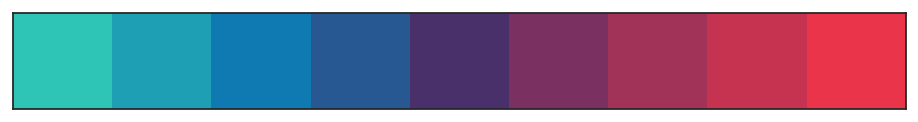

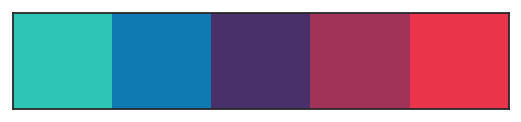

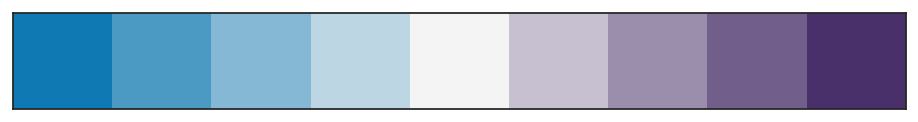

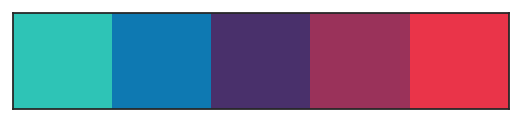

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [10]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [11]:
## How much data to use for model selection crossval
TRAIN_SIZE = 365

## How large the timeseriessplit window should be
WINDOW_SIZE = 7

## How many days for cv test
TEST_SIZE = 1

In [12]:
#df_all

In [13]:
def shift_split_data(df_, target_col, trainsize):
    df = df_.copy()
    df['Date_Y'] = df['Date'].shift(periods=-1)
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'Date':'Date_X'}, inplace=True)
    
    ## DF for prediction (only last trainsize days)
    ## Use to predict day after last df Date
    df_forprediction = df.iloc[trainsize:]
    
    ## DF for train + test (without last trainsize days)
    df_tt = df.iloc[:trainsize]
    return df_tt, df_forprediction
    
    

In [14]:
target_cols = [i for i in df_all if '_close' in i]

In [15]:
target_col = 'btc_close'

In [16]:
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

In [17]:
#df_tt

In [18]:
#df_forprediction

## Model Selection

In [19]:
target_cols = [i for i in df_all.columns if '_close' in i]

In [20]:
#df_tt.head(5)

### Set up pipeline

In [21]:
score_func = 'neg_mean_squared_error'

In [22]:
## Split X and Y

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

In [23]:
pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    DecisionTreeRegressor(random_state=RANDOM_STATE))

## Change params as needed
params_dt = {
    'selectkbest__k':[10,20,50],
    'decisiontreeregressor__max_depth': [2,3]
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )



In [24]:
# Fit GS to training data
gs_dtr.fit(X, Y)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=7, n_splits=45, test_size=1),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x121cf2940>)),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=9))]),
             n_jobs=-1,
             param_grid={'decisiontreeregressor__max_depth': [2, 3],
                         'selectkbest__k': [10, 20, 50]},
             scoring='neg_mean_squared_error')

In [25]:
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores


,mean_test_score,params,rank_test_score
1,-3.878591e+06,"{'decisiontreeregressor__max_depth': 2, 'selec...",1
0,-4.014695e+06,"{'decisiontreeregressor__max_depth': 2, 'selec...",2
3,-4.158015e+06,"{'decisiontreeregressor__max_depth': 3, 'selec...",3
4,-4.395009e+06,"{'decisiontreeregressor__max_depth': 3, 'selec...",4
2,-5.409881e+06,"{'decisiontreeregressor__max_depth': 2, 'selec...",5
5,-5.794895e+06,"{'decisiontreeregressor__max_depth': 3, 'selec...",6


In [26]:
gs_dtr.best_params_

{'decisiontreeregressor__max_depth': 2, 'selectkbest__k': 20}

In [27]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=20,
                             score_func=<function f_regression at 0x121cf2940>)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=2, random_state=9))])

In [28]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([40345.50757334])

In [29]:
april_26_truth = 38117.46
april_26_pred = 40345.51
mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.058452215861182856

In [30]:
mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.058452215861182856

## SKForecast

In [31]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import grid_search_sarimax


In [60]:
df_tt_skf = df_tt.copy()


In [64]:
df_tt_skf['Date_X'] = pd.to_datetime(df_tt_skf['Date_X'])

In [71]:
df_pr_skf = df_forprediction.copy()

In [72]:
df_pr_skf['Date_X'] = pd.to_datetime(df_pr_skf['Date_X'])

In [80]:
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=RANDOM_STATE),
                lags = 1
             )

param_grid0 = {}
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [1,7, 14, 21]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = df_tt_skf['Y'],
                        exog        = df_tt_skf[x_cols],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(df_tt_skf)*0.5),
                        return_best = True,
                        verbose     = False
                    )





forecaster.fit(y=df_tt_skf['Y'], exog=df_tt_skf[x_cols])



Number of models compared: 48


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [04:58<00:00, 74.57s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 16134267.020322226



MAPE:  0.06668681498866358


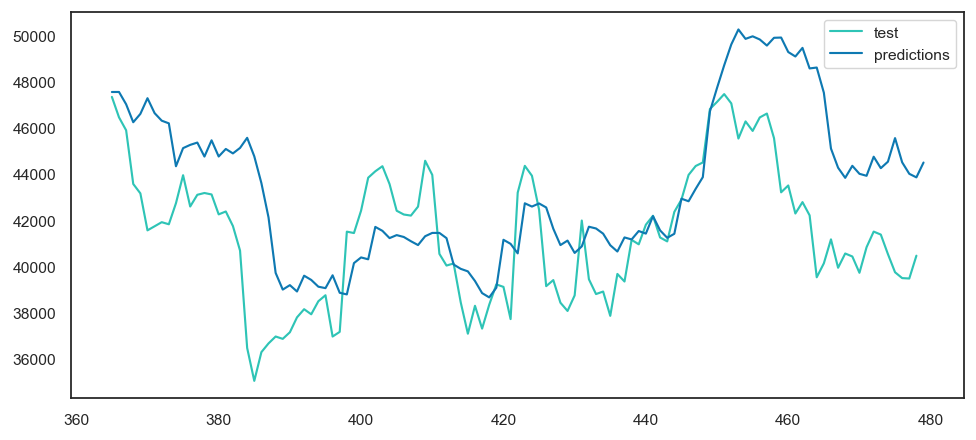

In [81]:
#`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#  Lags: [1 2 3 4 5 6 7] 
#  Parameters: {}
#  Backtesting metric: 22227460.928701684

#`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
#  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
#  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
#  Backtesting metric: 16134267.020322226

#forecaster
#results_grid.head()

steps = len(df_pr_skf)
predictions = pd.DataFrame(forecaster.predict(steps=steps, exog=df_pr_skf[x_cols]))
predictions = predictions.set_index(df_pr_skf.index)

fig, ax = plt.subplots(figsize=(9, 4))

## Plot actual test
df_pr_skf['Y'].plot(ax=ax, label='test', color=CAT_COLORS[0])

## Plot predictions
predictions['pred'].plot(ax=ax, label='predictions', color=CAT_COLORS[1])

ax.legend();

print("MAPE: ", mean_absolute_percentage_error(df_pr_skf['Y'][:-1],predictions['pred'][:-1]))

plt.show()

0.0746978642187345


In [77]:
df_pr_skf['Y'][:-1]

365    47345.218750
366    46458.117188
367    45897.574219
368    43569.003906
369    43160.929688
           ...     
474    40527.363281
475    39740.320312
476    39486.730469
477    39469.292969
478    40458.308594
Name: Y, Length: 114, dtype: float64

MAPE:  0.03786666501420965


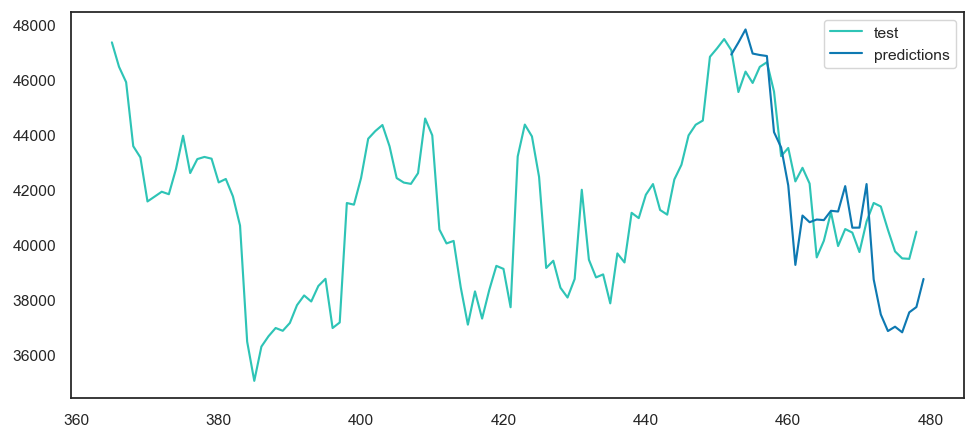

In [93]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=RANDOM_STATE),
                lags = 1
             )

forecaster.fit(y=df_tt_skf['Y'], exog=df_tt_skf[x_cols])


steps = 28
predictions = pd.DataFrame(forecaster.predict(steps=steps, exog=df_pr_skf[x_cols]))
predictions = predictions.set_index(df_pr_skf[-steps:].index)

fig, ax = plt.subplots(figsize=(9, 4))

## Plot actual test
df_pr_skf['Y'].plot(ax=ax, label='test', color=CAT_COLORS[0])

## Plot predictions
predictions['pred'].plot(ax=ax, label='predictions', color=CAT_COLORS[1])

ax.legend();

print('MAPE: ', mean_absolute_percentage_error(df_pr_skf[-steps:-1]['Y'],predictions['pred'][:-1]))

plt.show()

In [52]:
predictions

,pred
365,35271.716016
366,35271.716016
367,35783.075260
368,35271.716016
369,35599.037760
370,38317.245052
371,43268.532552
372,44417.968229
373,44526.197396
374,38774.331771
